In [2]:
import torch
import torch.nn as nn
import util
from torch.utils.data import DataLoader
import re
import collections
import numpy as np
import math
from torch.nn import functional as F

# Working with Sequences

In [3]:
class Data(util.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

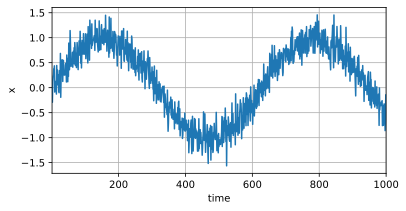

In [4]:
data = Data()
util.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

### Net

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

### Evaluate loss

In [6]:
def evaluate_loss(net, data_iter, loss, device):
    sum_loss = 0
    num = 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        predict = net(X)
        curr_loss = loss(predict, y)
        sum_loss += torch.sum(curr_loss)
        num += len(curr_loss)
    return sum_loss / num

## Train

In [7]:
def train(net, train_iter, loss, epochs, lr, device):
    net.to(device)
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}', f'loss {evaluate_loss(net, train_iter, loss, device)}')

net = get_net()
train(net, data.get_dataloader(train=True), loss, 5, 0.01, 'cuda:0')

epoch 1 loss 0.07815060764551163
epoch 2 loss 0.05558564513921738
epoch 3 loss 0.054796621203422546
epoch 4 loss 0.05350985378026962
epoch 5 loss 0.05309949815273285


## prediction

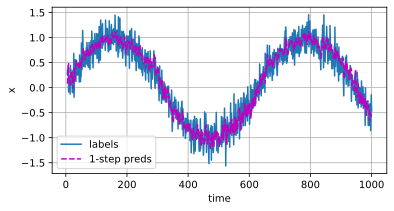

In [8]:
X = data.features.to('cuda:0')
onestep_preds = net(X).detach()
onestep_preds = onestep_preds.to('cpu').numpy()
util.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

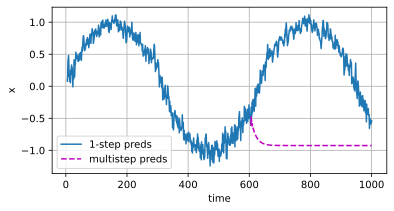

In [9]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
multistep_preds = multistep_preds.to(device='cuda:0')
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = net(multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.to('cpu') 
multistep_preds = multistep_preds.detach().numpy()

util.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

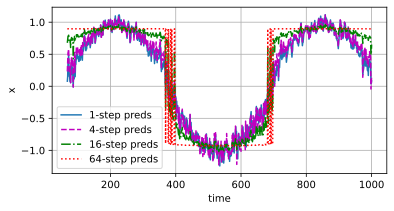

In [10]:
def k_step_pred(k, device):
    features = []
    for i in range(data.tau):
        feature = data.x[i: i+data.T-data.tau-k+1].to(device)
        features.append(feature)

    for i in range(k):
        preds = net(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1], 'cuda:0')
util.plot(data.time[data.tau+steps[-1]-1:], [preds[k-1].to('cpu').detach().numpy() for  k in steps], 'time', 'x', legend=[f'{k}-step preds' for k in steps], figsize=(6,3))

# Converting Raw Text into Sequence Data

In [11]:
class Vocab:
    """Vocabulary for text"""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens +
                                            [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    @property
    def unk(self):
        return self.token_to_idx['<unk>']

In [12]:
class TimeMachine(util.DataModule):
    """The Time Machine dataset"""
    def _download(self):
        fname = util.download(util.DATA_URL + 'timemachine.txt', '/home/tongyq24/tongyq24Files/code/Modeling_Framework/data', sha1_hash='090b5e7e70c295757f55df93cb0a180b9691891a')

        with open(fname) as f:
            return f.read()
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()
    
    def _tokenize(self, text):
        return list(text)
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [13]:
text = data._preprocess(raw_text)
text[:60]
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [14]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [15]:
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [16]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [17]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [18]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

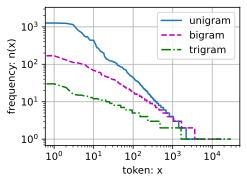

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
util.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log',
          legend=['unigram', 'bigram', 'trigram'])

# Language Models

In [20]:
@util.add_to_class(TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus) - num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [21]:
@util.add_to_class(TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [22]:
data = TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[20,  0, 20,  9, 16, 15,  6,  0,  2, 15],
        [ 6, 16, 17, 13,  6,  0, 17, 19, 16,  4]]) 
Y: tensor([[ 0, 20,  9, 16, 15,  6,  0,  2, 15,  5],
        [16, 17, 13,  6,  0, 17, 19, 16,  4,  6]])


# Recurrent Neural Network Implemention from Scratch

## RNN Model

In [23]:
class RNNScratch(util.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [24]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [25]:
def check_len(a, n): 
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape): 
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN-Based Language Model

In [26]:
class RNNLMScratch(util.Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
    
    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)  

## One-Hot Encoding

In [27]:
@util.add_to_class(RNNLMScratch)
def one_hot(self, X):
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

## Transforming RNN Outputs

In [28]:
@util.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@util.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [29]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

## Gradient Clipping

In [30]:
@util.add_to_class(util.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *=  grad_clip_val / norm


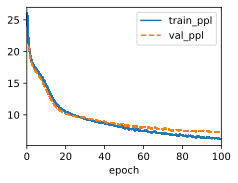

In [31]:
data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = util.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [32]:
@util.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  
            outputs.append(vocab[prefix[i + 1]])
        else:  
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [33]:
model.predict('it has', 20, data.vocab, util.try_gpu())

'it has of the the the peal'

# Concise Implementation of Recurrent Neural Networks

In [34]:
class RNN(util.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [35]:
class RNNLM(RNNLMScratch):
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [36]:
data = TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasdtzqzczczczczczczczc'